In [85]:
import glob
#from pathlib import Path
import json
import preprocessing as pp
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
keys_to_dtype = {
  #'developer_token_id': tf.int64,
  #'resource_token_id': tf.int64,
  #'screen_caption_token_ids': tf.int64,
  #'appdesc_token_id': tf.int64,
  'clickable_seq': tf.int64,
  'type_id_seq': tf.int64,
  'cord_x_seq': tf.float32,
  'cord_y_seq': tf.float32,
  'visibility_to_user_seq': tf.int64,
  'visibility_seq': tf.int64,
  #'attended_objects': tf.int64,
  #'label_flag': tf.int64,  # 0: padding 1: node
  # 'obj_img_mat': tf.int64,
  'obj_dom_pos': tf.int64,
  #'attention_boxes': tf.float32,
  #'gold_caption': tf.string,
}

In [7]:
def get_features_from_gestures(gesture_path):
  with tf.io.gfile.GFile(gesture_path) as f:
    gesture_json = json.load(f)
  trace_path = gesture_path.replace('gestures.json', '')
  # Throw away all gestures except the first
  gesture_dict = {gesture[0]:gesture[1][0] for gesture in gesture_json.items()}
  gesture_df = pd.DataFrame(gesture_dict).transpose()
  gesture_df.columns = ['x', 'y']
  return gesture_df, trace_path

In [15]:
def to_var_len_feature_dict(entries):
  dict = {}
  for feature_item in entries:
    dict[feature_item[0]] = tf.convert_to_tensor(feature_item[1], dtype=keys_to_dtype[feature_item[0]])
  return dict


In [16]:
#pathToCombined = "D:/Tmp/Coding/datasets/RICO/unique_uis/test_dataset"
traces_prefix = "../sources/datasets/RICO/traces/filtered_traces"
path_to_gesture_json = f"{traces_prefix}/*/trace_*/gestures.json"
path_to_gesture_json

'../sources/datasets/RICO/traces/filtered_traces/*/trace_*/gestures.json'

In [21]:
gesture_json_paths = glob.glob(path_to_gesture_json)
gesture_json_paths

['../sources/datasets/RICO/traces/filtered_traces/muchoapps.frasesdelavida/trace_1/gestures.json',
 '../sources/datasets/RICO/traces/filtered_traces/muchoapps.frasesdelavida/trace_2/gestures.json',
 '../sources/datasets/RICO/traces/filtered_traces/yourapp24.android.tools.alice_lite/trace_0/gestures.json',
 '../sources/datasets/RICO/traces/filtered_traces/yourapp24.android.tools.alice_lite/trace_1/gestures.json',
 '../sources/datasets/RICO/traces/filtered_traces/yourapp24.android.tools.alice_lite/trace_2/gestures.json']

In [40]:
def get_features_from_tree(frame_index, trace_path):
  file_prefix = f"{trace_path}view_hierarchies/{frame_index}"
  features_dict = pp.create_simple_features(file_prefix)
  del features_dict['node_id']
  feature_items = list(features_dict.items())
  #feature_items = to_var_len_feature_dict(feature_items).items()
  tree_feature_df = pd.DataFrame(feature_items, columns=['feat', frame_index])
  tree_feature_df = tree_feature_df.set_index('feat')
  tree_feature_df = tree_feature_df.transpose()
  return tree_feature_df
  return pd.DataFrame(features_adapt, index=[frame_index])

In [41]:
gesture_path = gesture_json_paths[1]
gesture_df, trace_path = get_features_from_gestures(gesture_path)
frameIndex = gesture_df.index.values[1]
feature_df = get_features_from_tree(frameIndex, trace_path)
feature_df
#feature_item = features[0]
#feature_item
#tf.convert_to_tensor(feature_item[1], dtype=keys_to_dtype[feature_item[0]])

feat,obj_dom_pos,type_id_seq,visibility_seq,visibility_to_user_seq,clickable_seq,cord_x_seq,cord_y_seq
4758,"[1, 1, 39, 2, 2, 38, 2, 38, 2, 2, 39, 1, 3, 3,...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0...","[[0.0, 1.0], [0.0, 0.934375], [0.934375, 1.0],..."


In [9]:
# gesture_df['x'].dtype # float64
# gesture_df['y'].dtype # float64

In [49]:
# for t,v in keys_to_dtype.items():
#     print(feature_df[t]['4758'][0].dtype)

In [43]:
# Try without features for now, only gestures
# all_feat_df = pd.concat([gesture_df, feature_df], axis=1)
all_feat_df = gesture_df
all_feat_df

,x,y
1457,0.291129,0.675567
4758,0.210429,0.066756


In [50]:
#feature_df['type_id_seq'].iloc[0][0].dtype

In [55]:
 # Get set of frames for each screen, but don't mix them during training LSTM
all_features_df = pd.DataFrame()
for trace_id, gesture_path in enumerate(gesture_json_paths):
    gesture_df, trace_path = get_features_from_gestures(gesture_path)
    if False: # Try without features for now, only gestures
        tree_features_df = pd.DataFrame()
        for frame_id in gesture_df.index.values:
            tree_feature_df = get_features_tensor_from_tree(frame_id, trace_path)
            tree_features_df = pd.concat([tree_features_df, tree_feature_df], axis=0)
        trace_features_df = pd.concat([gesture_df, tree_features_df], axis=1)
    else:
        trace_features_df = gesture_df
    #trace_features_df = tree_feature_df
    # TODO: save in list of traces
    #trace_features_df['trace_id'] = trace_id
    all_features_df = pd.concat([all_features_df, trace_features_df], axis=0)
    
all_features_df.head()
        

,x,y
2,0.094011,0.083688
457,0.969031,0.026950
2160,0.454610,0.648227
2677,0.068794,0.070922
4998,0.880772,0.821277


In [62]:
# TODO: split by trace id
df = all_features_df
test_size = len(df) // 4
test_ind = len(df) - test_size

train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [63]:
#df['obj_dom_pos'].dtype

In [64]:
from keras.layers import Normalization

scaler = Normalization()
scaler_invert = Normalization(invert=True)

scaler.adapt(train)
scaler_invert.adapt(train)

scaled_train = scaler(train)
scaled_test = scaler(test)

print(scaler_invert(scaled_train))

tf.Tensor(
[[0.09401104 0.08368796]
 [0.96903074 0.02695036]
 [0.45460993 0.648227  ]
 [0.06879434 0.07092199]
 [0.88077223 0.8212766 ]
 [0.2957447  0.45957446]
 [0.1217494  0.13617021]
 [0.8782506  0.83120567]
 [0.2911289  0.67556745]
 [0.21042871 0.06675565]
 [0.21929823 0.75866497]
 [0.08693483 0.762516  ]
 [0.45767197 0.0616883 ]
 [0.28643578 0.9599567 ]
 [0.2113997  0.9599567 ]
 [0.0940356  0.7748918 ]
 [0.7672476  0.7663399 ]
 [0.20951344 0.9591503 ]
 [0.3663762  0.9591503 ]], shape=(19, 2), dtype=float32)


In [65]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [101]:
length = 5
n_features=2
label_length=1

In [119]:
scaled_train

<tf.Tensor: shape=(19, 2), dtype=float32, numpy=
array([[-9.5306593e-01, -1.3609554e+00],
       [ 2.1074693e+00, -1.5205547e+00],
       [ 3.0819210e-01,  2.2705747e-01],
       [-1.0412657e+00, -1.3968652e+00],
       [ 1.7987696e+00,  7.1383524e-01],
       [-2.4746703e-01, -3.0361024e-01],
       [-8.5604614e-01, -1.2133261e+00],
       [ 1.7899498e+00,  7.4176502e-01],
       [-2.6361153e-01,  3.0396450e-01],
       [-5.4587466e-01, -1.4085850e+00],
       [-5.1485193e-01,  5.3771263e-01],
       [-9.7781622e-01,  5.4854536e-01],
       [ 3.1890213e-01, -1.4228390e+00],
       [-2.8002656e-01,  1.1039337e+00],
       [-5.4247844e-01,  1.1039337e+00],
       [-9.5298004e-01,  5.8335763e-01],
       [ 1.4016974e+00,  5.5930173e-01],
       [-5.4907596e-01,  1.1016654e+00],
       [-4.2091653e-04,  1.1016654e+00]], dtype=float32)>

In [115]:
# Replace by timeseries_dataset_from_array
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)
len(generator)

14

In [117]:
X,y = generator[0]
X

array([[[-0.95306593, -1.3609554 ],
        [ 2.1074693 , -1.5205547 ],
        [ 0.3081921 ,  0.22705747],
        [-1.0412657 , -1.3968652 ],
        [ 1.7987696 ,  0.71383524]]], dtype=float32)

In [118]:
y

array([[-0.24746703, -0.30361024]], dtype=float32)

In [143]:
def split_window(features):
  inputs = features[:, slice(0, length), :]
  labels = features[:, slice(length, length + label_length), :]
  return inputs, labels

def make_dataset(data):
  ds = tf.keras.utils.timeseries_dataset_from_array(
    data=data,
    targets=None,
    sequence_length=length + label_length,
    sequence_stride=1,
    shuffle=False, # TODO: Shuffle if possible
    batch_size=32,)

  ds = ds.map(split_window)

  return ds

dataset = make_dataset(scaled_train)
validaton_dataset = make_dataset(scaled_test)

# dataset
# dataset = tf.data.Dataset.from_tensor_slices(scaled_train).window(length, drop_remainder=True)
# for inputs, labels in dataset:
#     print(len(inputs))
#     print(list(inputs.numpy()))

inputs, labels = next(iter(dataset))
inputs

<tf.Tensor: shape=(14, 5, 2), dtype=float32, numpy=
array([[[ 1.7899498 ,  0.741765  ],
        [-0.26361153,  0.3039645 ],
        [-0.54587466, -1.408585  ],
        [-0.5148519 ,  0.53771263],
        [-0.9778162 ,  0.54854536]],

       [[-0.5148519 ,  0.53771263],
        [-0.9778162 ,  0.54854536],
        [ 0.31890213, -1.422839  ],
        [-0.28002656,  1.1039337 ],
        [-0.54247844,  1.1039337 ]],

       [[ 2.1074693 , -1.5205547 ],
        [ 0.3081921 ,  0.22705747],
        [-1.0412657 , -1.3968652 ],
        [ 1.7987696 ,  0.71383524],
        [-0.24746703, -0.30361024]],

       [[-0.28002656,  1.1039337 ],
        [-0.54247844,  1.1039337 ],
        [-0.95298004,  0.58335763],
        [ 1.4016974 ,  0.55930173],
        [-0.54907596,  1.1016654 ]],

       [[-0.9778162 ,  0.54854536],
        [ 0.31890213, -1.422839  ],
        [-0.28002656,  1.1039337 ],
        [-0.54247844,  1.1039337 ],
        [-0.95298004,  0.58335763]],

       [[ 1.7987696 ,  0.71383524],
  

In [144]:
labels

<tf.Tensor: shape=(14, 1, 2), dtype=float32, numpy=
array([[[ 3.1890213e-01, -1.4228390e+00]],

       [[-9.5298004e-01,  5.8335763e-01]],

       [[-8.5604614e-01, -1.2133261e+00]],

       [[-4.2091653e-04,  1.1016654e+00]],

       [[ 1.4016974e+00,  5.5930173e-01]],

       [[-5.4587466e-01, -1.4085850e+00]],

       [[-9.7781622e-01,  5.4854536e-01]],

       [[-2.4746703e-01, -3.0361024e-01]],

       [[-2.6361153e-01,  3.0396450e-01]],

       [[-5.1485193e-01,  5.3771263e-01]],

       [[-5.4907596e-01,  1.1016654e+00]],

       [[ 1.7899498e+00,  7.4176502e-01]],

       [[-2.8002656e-01,  1.1039337e+00]],

       [[-5.4247844e-01,  1.1039337e+00]]], dtype=float32)>

In [145]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [146]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [147]:
model.fit(dataset,epochs=50,
                    validation_data=validaton_dataset,
                    callbacks=[early_stop])

Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.7730 - val_loss: 0.7756
Epoch 2/50
1/1 [==============================] - 0s 69ms/step - loss: 0.7671 - val_loss: 0.7504
Epoch 3/50
1/1 [==============================] - 0s 73ms/step - loss: 0.7616 - val_loss: 0.7260
Epoch 4/50
1/1 [==============================] - 0s 87ms/step - loss: 0.7567 - val_loss: 0.7024
Epoch 5/50
1/1 [==============================] - 0s 101ms/step - loss: 0.7522 - val_loss: 0.6793
Epoch 6/50
1/1 [==============================] - 0s 99ms/step - loss: 0.7481 - val_loss: 0.6569
Epoch 7/50
1/1 [==============================] - 0s 80ms/step - loss: 0.7444 - val_loss: 0.6346
Epoch 8/50
1/1 [==============================] - 0s 71ms/step - loss: 0.7411 - val_loss: 0.6128
Epoch 9/50
1/1 [==============================] - 0s 89ms/step - loss: 0.7383 - val_loss: 0.5915
Epoch 10/50
1/1 [==============================] - 0s 136ms/step - loss: 0.7358 - val_loss: 0.5708
Epoch 11/50
1/1 [============

<AxesSubplot: >

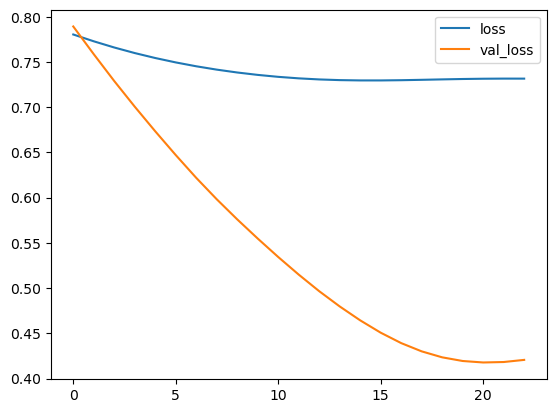

In [142]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [72]:
## Evaluate on Test Data

In [154]:
scaled_train

<tf.Tensor: shape=(19, 2), dtype=float32, numpy=
array([[-9.5306593e-01, -1.3609554e+00],
       [ 2.1074693e+00, -1.5205547e+00],
       [ 3.0819210e-01,  2.2705747e-01],
       [-1.0412657e+00, -1.3968652e+00],
       [ 1.7987696e+00,  7.1383524e-01],
       [-2.4746703e-01, -3.0361024e-01],
       [-8.5604614e-01, -1.2133261e+00],
       [ 1.7899498e+00,  7.4176502e-01],
       [-2.6361153e-01,  3.0396450e-01],
       [-5.4587466e-01, -1.4085850e+00],
       [-5.1485193e-01,  5.3771263e-01],
       [-9.7781622e-01,  5.4854536e-01],
       [ 3.1890213e-01, -1.4228390e+00],
       [-2.8002656e-01,  1.1039337e+00],
       [-5.4247844e-01,  1.1039337e+00],
       [-9.5298004e-01,  5.8335763e-01],
       [ 1.4016974e+00,  5.5930173e-01],
       [-5.4907596e-01,  1.1016654e+00],
       [-4.2091653e-04,  1.1016654e+00]], dtype=float32)>

In [155]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
#print(first_eval_batch)
current_batch = first_eval_batch
current_batch = tf.reshape(first_eval_batch, (1, length, n_features), name=None)

for i in range(len(test)):

  # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
  current_pred = model.predict(current_batch)[0]

  # store prediction
  test_predictions.append(current_pred)

  # update batch to now include prediction and drop first value
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 17ms/step


In [159]:
true_predictions = scaler_invert(test_predictions)
test[['PredictionsX', 'PredictionsY']] = true_predictions

/tmp/ipykernel_52227/4294280599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['PredictionsX', 'PredictionsY']] = true_predictions
/tmp/ipykernel_52227/4294280599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['PredictionsX', 'PredictionsY']] = true_predictions


In [160]:
test

,x,y,PredictionsX,PredictionsY
1340,0.880537,0.781046,0.310699,0.660990
1363,0.279230,0.903595,0.317054,0.657010
1379,0.427378,0.364379,0.322807,0.650084
1394,0.087509,0.955882,0.331946,0.634408
1428,0.255991,0.949346,0.338462,0.622150
1455,0.194989,0.955882,0.344178,0.611629


<AxesSubplot: >

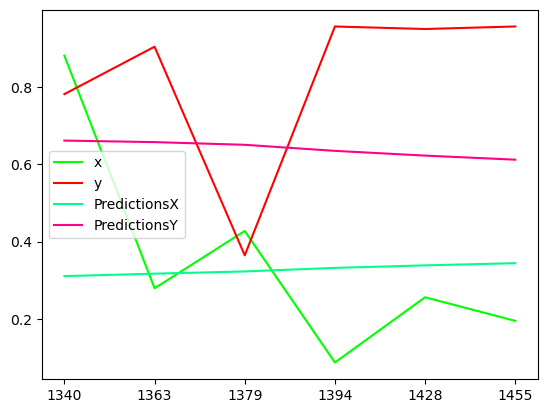

In [167]:
test.plot(color = ['#00FF00', '#FF0000', '#00FF88', '#FF0088'])

In [170]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(test['x'],test['PredictionsX'])))
print(np.sqrt(mean_squared_error(test['y'],test['PredictionsY'])))

0.2664237030456812
0.2845341108456235
